In [1]:
# https://wikidocs.net/233348
# https://medium.com/the-modern-scientist/prompt-engineering-classification-of-techniques-and-prompt-tuning-6d4247b9b64c

In [2]:
# pip install langchain

In [3]:
# pip install -U langchain-ollama

In [4]:
# pip install langchain_teddynote
#  ollama create llama-3.1-70b-instruct-lorablated.Q4_K_M:latest -f Modelfile
# ollama create llama-3.1-70b-instruct-lorablated.Q4_K_M:latest -f Modelfile_73

In [5]:

import warnings
import langchain
from langchain_ollama.llms import OllamaLLM
from langchain_core.prompts.few_shot import FewShotPromptTemplate
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.messages import stream_response
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

warnings.filterwarnings("ignore", category=DeprecationWarning)
# https://wikidocs.net/233348

In [6]:
df = pd.read_csv('../../data/part_one_q_output.csv', index_col = 0)

In [7]:
df['question'][0]

'Here is the question about software development. The title of the question is <Title>Why joblib is not recommended when saving keras model?</Title>. and body of the question is <Question>According to this keras documentation, pickle is not recommended to save keras mode, and since joblib.dump() and joblib.load() are based on the Python pickle serialization model, joblib is also not recommended to save keras model. What is the reason for that ?\n</Question>. Please answer briefly about the "difficulty" of the stackoverflow question'

In [8]:
llm = OllamaLLM(model="llama-3.1-70b-instruct-lorablated.Q4_K_M:latest")
parser = StrOutputParser()
# llm = OllamaLLM(model="llama3.1:70b")


In [9]:
df.shape[0]

43

In [10]:
df_plot = df['answer'].value_counts().to_frame().reset_index()

In [11]:
df_plot.loc[df_plot['answer']=='Difficulty class : Basic', 'count'].values[0]

9

In [12]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(3)
di_dict = {}
for di in ['Difficulty class : Basic', 'Difficulty class : Intermediate', 'Difficulty class : Advanced']:
    di_dict[di] = df_plot.loc[df_plot['answer']==di, 'count'].values[0]
print(list(di_dict.values()))

[9, 27, 7]


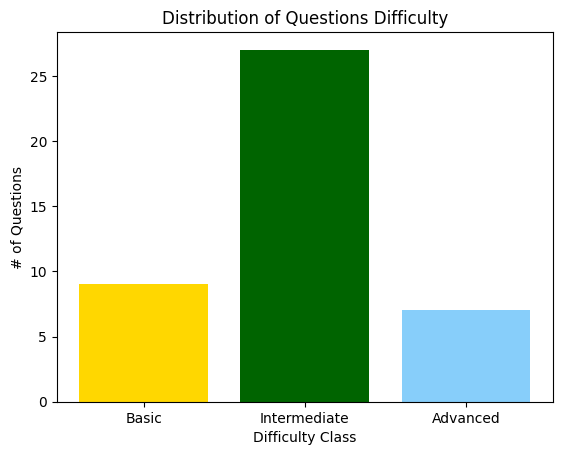

In [13]:
plt.bar(  x
        , list(di_dict.values())
        , color = ['gold', 'darkgreen', 'lightskyblue']
        , width = 0.8
        , label = list(di_dict.keys()))
plt.xticks(x, [x.replace('Difficulty class : ', '') for x in list(di_dict.keys())] )
# plt.legend()

plt.ylabel('# of Questions')
plt.xlabel('Difficulty Class')
# plt.xticks(rotation = 45)
plt.title('Distribution of Questions Difficulty')

plt.show()


In [14]:
diff_idx = {x : list(df[df['answer']==x].index) for x in list(di_dict.keys())}

In [15]:
diff_s_idx = {}
for key, value in diff_idx.items():
    print(key, value)
    dic_col = f'{key}_sample_idx'
    diff_population = value
    np.random.seed(222)
    diff_s_idx[dic_col] = np.random.choice(diff_population, size=4, replace=False)

Difficulty class : Basic [10, 21, 23, 25, 31, 35, 36, 38, 40]
Difficulty class : Intermediate [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 24, 26, 28, 29, 30, 32, 33, 37, 39]
Difficulty class : Advanced [0, 9, 20, 27, 34, 41, 42]


In [16]:
diff_s_idx

{'Difficulty class : Basic_sample_idx': array([31, 21, 36, 23]),
 'Difficulty class : Intermediate_sample_idx': array([37,  1, 12, 28]),
 'Difficulty class : Advanced_sample_idx': array([34,  9, 27, 20])}

In [17]:
from itertools import chain

fewshot_q_id = list(chain.from_iterable(diff_s_idx.values()))


In [18]:
eval_q_id =np.setdiff1d(list(df.index), fewshot_q_id)

In [19]:
examples = []
for idx in fewshot_q_id:
# for idx in [19]:
    temp_dict = {"question" : str(df.loc[idx, 'question']),
                 "answer"   : str(df.loc[idx, 'answer'])}
    examples.append(temp_dict)

In [20]:
example_prompt = PromptTemplate.from_template(
    "**Question**\n{question}\n**Answer**\n{answer}"
)

print(example_prompt.format(**examples[0]))

**Question**
Here is the question about software development. The title of the question is <Title>How do I iterate for all HDF5 files and save them as csv files</Title>. and body of the question is <Question>I am writing a python code that will loop over my SMAP HDF5 (10,000) files. I want to extract soil moisture rootzone and vegetation greenness. My code looks like this




I get an error like this




I expect to get csv files of the same filenames with only soil moisture and vegetation greenness. I want also to clip the values to these coordinates
box_lat = [-43.63, -10.66]
box_lon = [113.34, -153.57]
How do I revise my code? Please help me 
</Question>. Please answer briefly about the "difficulty" of the stackoverflow question
**Answer**
Difficulty class : Basic


In [21]:
prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="**Question**\n{question}\n**Answer**",
    input_variables=["question"],
)

In [27]:
eval_result = pd.DataFrame(columns = ['id', 'result'])
for idx in tqdm(eval_q_id):
    question = df.loc[idx, 'question']
    print(question)
    final_prompt = prompt.format(question=question)
    chain = prompt | llm | parser

    # chain 호출
    response = chain.invoke({"question": question})
    tmp_dict = {'id' : df.loc[idx, 'id']
                ,'result' : response}
    eval_result = pd.concat([eval_result, pd.DataFrame([tmp_dict])], ignore_index=True)

  0%|          | 0/31 [00:00<?, ?it/s]

Here is the question about software development. The title of the question is <Title>Why joblib is not recommended when saving keras model?</Title>. and body of the question is <Question>According to this keras documentation, pickle is not recommended to save keras mode, and since joblib.dump() and joblib.load() are based on the Python pickle serialization model, joblib is also not recommended to save keras model. What is the reason for that ?
</Question>. Please answer briefly about the "difficulty" of the stackoverflow question


KeyError: '"A"'

In [23]:
result_df = pd.merge(df,eval_result, on = 'id' )

In [ ]:
result_df.head()

In [25]:
result_df['answer_diff_class'] = [x[1] for x in result_df['answer'].str.split(r"[|:]+")]


In [26]:
result_df['result_diff_class']  = [x[1] for x in result_df['result'].str.split(r"[|:]+")]


In [ ]:
result_df.head()

In [ ]:
result_df.head(10)

In [29]:
result_df['answer_diff_class'] = result_df['answer_diff_class'].str.strip()
result_df['result_diff_class'] = result_df['result_diff_class'].str.strip()

In [30]:
result_df['answer_diff_class_0'] = [x[0] for x in result_df['answer_diff_class'].str.split(' ')]
result_df['result_diff_class_0'] = [x[0] for x in result_df['result_diff_class'].str.split(' ')]

In [31]:
result_df['equal_yn'] = np.where(result_df['answer_diff_class_0']==result_df['result_diff_class_0'], 1, 0)

In [ ]:
acc = (result_df['equal_yn'].sum()/result_df.shape[0])*100
print(acc)

In [ ]:
result_df[result_df['equal_yn']==0]

In [28]:
pd.DataFrame(examples).to_csv('chk.csv')

TypeError: object of type 'PromptTemplate' has no len()